# Object Detection on Waste Recycling Plant Dataset

In this notebook you will:
- Train 
- Validate
- Test
 
a yolov8 custom model

Source of dataset: https://www.kaggle.com/datasets/parohod/warp-waste-recycling-plant-dataset?select=.idea 

## Before you start ( i know its a lot of folders 😓)

Create an <mark>'exam'</mark> folder in your Google Drive

In the exam folder create a <mark>'yolov8'</mark> folder

In the yolov8 folder create a <mark>'data'</mark> folder

Upload your test data and your train data folders into the 'data' folder. (Note: images and labels should be in seperate files)


FOR REFERENCE:
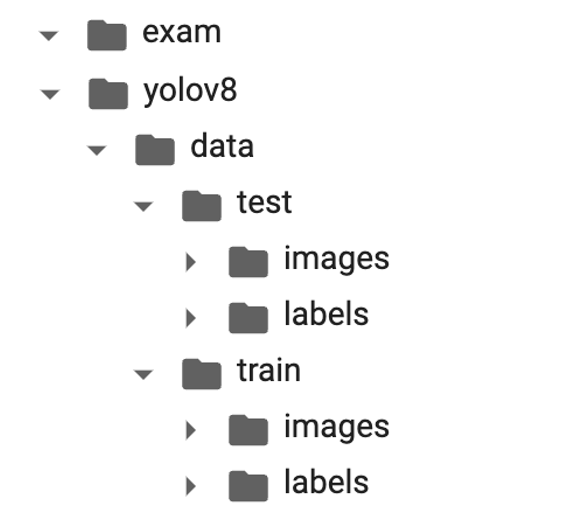

# Train Model

#### Check acces to GPU

Let's make sure that we have access to GPU.

In [ ]:
!nvidia-smi

Sun Apr 16 22:44:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Installation

In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.6/515.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 9.9 MB/s eta 0:00:00


Import libraries for training and splitting data

In [ ]:
import os
import shutil
import random

from tqdm.notebook import tqdm

Connect to google drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Split data into train and validation set

In [ ]:
#create file paths for the training and validation sets
train_path_img = "./yolo_data/images/train/"
train_path_label = "./yolo_data/labels/train/"
val_path_img = "./yolo_data/images/val/"
val_path_label = "./yolo_data/labels/val/"

In [ ]:
# Define a function for splitting training data to train and validation
def train_test_split(path,neg_path=None, split = 0.2):
    print("------ PROCESS STARTED -------")


    files = list(set([name[:-4] for name in os.listdir(path)])) ## removing duplicate names i.e. counting only number of images
    

    print (f"--- This folder has a total number of {len(files)} images---")
    random.seed(42)
    random.shuffle(files)

    # split the data 
    test_size = int(len(files) * split)
    train_size = len(files) - test_size

    ## creating required directories for the images and their labels

    os.makedirs(train_path_img, exist_ok = True)
    os.makedirs(train_path_label, exist_ok = True)
    os.makedirs(val_path_img, exist_ok = True)
    os.makedirs(val_path_label, exist_ok = True)

    
    ### copying images and labels to train folder
    for filex in tqdm(files[:train_size]):
      if filex == 'classes':
          continue
      shutil.copy2(path + filex + '.jpg',f"{train_path_img}/" + filex + '.jpg' )
      shutil.copy2(path[0:43] + 'labels/'  + filex + '.txt', f"{train_path_label}/" + filex + '.txt')
        
    

    print(f"------ Training data created with 80% split {len(files[:train_size])} images -------")
    
    if neg_path:
        neg_images = list(set([name[:-4] for name in os.listdir(neg_path)])) ## removing duplicate names i.e. counting only number of images
        for filex in tqdm(neg_images):
            shutil.copy2(neg_path+filex+ ".jpg", f"{train_path_img}/" + filex + '.jpg')
            
        print(f"------ Total  {len(neg_images)} negative images added to the training data -------")
    
        print(f"------ TOTAL Training data created with {len(files[:train_size]) + len(neg_images)} images -------")
    


    ### copyt images and labels to validation folder
    for filex in tqdm(files[train_size:]):
      if filex == 'classes':
          continue
      # print("running")
      shutil.copy2(path + filex + '.jpg', f"{val_path_img}/" + filex + '.jpg' )
      shutil.copy2(path[0:43] + 'labels/' + filex + '.txt', f"{val_path_label}/" + filex + '.txt')

    print(f"------ Validation data created with a total of {len(files[train_size:])} images ----------")
    
    print("------ TASK COMPLETED -------")

In [ ]:
# split data
# Note: it may take 20mins to run
train_test_split('/content/drive/MyDrive/exam/unsampled data/images/')

------ PROCESS STARTED -------
--- This folder has a total number of 2452 images---


  0%|          | 0/1962 [00:00<?, ?it/s]

------ Training data created with 80% split 1962 images -------


  0%|          | 0/490 [00:00<?, ?it/s]

------ Validation data created with a total of 490 images ----------
------ TASK COMPLETED -------


Create yaml file for training

In [ ]:
import yaml

In [ ]:
# infomation for yaml document
data = {
    'train': '/content/yolo_data/images/train', # path to training images
    'val': '/content/yolo_data/images/val', #path to validation images

    'nc': 28, # number of classes 
    'names': ['bottle-blue', 'bottle-green', 'bottle-dark', 'bottle-milk', 'bottle-transp', 'bottle-multicolor', 'bottle-yogurt', 'bottle-oil', 'cans', 'juice-cardboard', 'milk-cardboard', 'detergent-color', 'detergent-transparent', 'detergent-box', 'canister', 'bottle-blue-full', 'bottle-transp-full', 'bottle-dark-full', 'bottle-green-full', 'bottle-multicolor-full', 'bottle-milk-full', 'bottle-oil-full', 'detergent-white', 'bottle-blue5l', 'bottle-blue5l-full', 'glass-transp', 'glass-dark', 'glass-green'] #class names 
}

In [ ]:
# create yaml file 
with open("dataset.yaml" , "w") as f:
   yaml.dump(data,f,default_flow_style = False)

In [ ]:
# save yaml file to google drive
!cp /content/dataset.yaml /content/drive/MyDrive/exam/yolov8/dataset.yaml

Check environment

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.80 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.6/78.2 GB disk)


Train model

In [ ]:
!yolo task=detect mode=train model=yolov8m.pt data=/content/drive/MyDrive/exam/yolov8/dataset.yaml epochs=200 imgsz=640 batch=16 patience=20 image_weights=True project=/content/drive/MyDrive/exam/yolov8/training_results name=garbage_detection

# comment the code above and uncomment the code below to resume training if notebook is interupted
# Note: you will need to run all the previous lines of code

#!yolo task=detect mode=train resume data=/content/drive/MyDrive/exam/yolov8/dataset.yaml model=/content/drive/MyDrive/exam/yolov8/training_results/garbage_detection/weights/last.pt

100% 49.7M/49.7M [00:00<00:00, 62.8MB/s]
New https://pypi.org/project/ultralytics/8.0.81 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.80 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/exam/yolov8/dataset.yaml, epochs=200, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/exam/yolov8/training_results, name=garbage_detection, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=True, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

## Validate model 

Validate model on unseen data

Note: the test data will be used in this case. It will be split into 10 for visual testing and the rest for validation metrics 

Define paths for validation images

In [ ]:
#create file paths for the training and validation sets
validation_path_img = "./yolo_val_data/images/validation/"
validation_path_label = "./yolo_val_data/labels/validation/"
test_path_img = "./yolo_val_data/images/test/"
test_path_label = "./yolo_val_data/labels/test/"

In [ ]:
# Define a function for splitting data into validation and test
def train_test_split(path,neg_path=None, split = 0.04):
    print("------ PROCESS STARTED -------")


    files = list(set([name[:-4] for name in os.listdir(path)])) ## removing duplicate names i.e. counting only number of images
    

    print (f"--- This folder has a total number of {len(files)} images---")
    random.seed(42)
    random.shuffle(files)

    # split the data 
    test_size = int(len(files) * split)
    train_size = len(files) - test_size

    ## creating required directories for the images and their labels

    os.makedirs(validation_path_img, exist_ok = True)
    os.makedirs(validation_path_label, exist_ok = True)
    os.makedirs(test_path_img, exist_ok = True)
    os.makedirs(test_path_label, exist_ok = True)

    
    ### copying images and labels to train folder
    for filex in tqdm(files[:train_size]):
      if filex == 'classes':
          continue
      shutil.copy2(path + filex + '.jpg',f"{validation_path_img}/" + filex + '.jpg' )
      shutil.copy2(path[0:48] + 'labels/'  + filex + '.txt', f"{validation_path_label}/" + filex + '.txt')
        
    

    print(f"------ Validation data created with 2% split {len(files[:train_size])} images -------")
    
    if neg_path:
        neg_images = list(set([name[:-4] for name in os.listdir(neg_path)])) ## removing duplicate names i.e. counting only number of images
        for filex in tqdm(neg_images):
            shutil.copy2(neg_path+filex+ ".jpg", f"{validation_path_img}/" + filex + '.jpg')
            
        print(f"------ Total  {len(neg_images)} negative images added to the training data -------")
    
        print(f"------ TOTAL Validation data created with {len(files[:train_size]) + len(neg_images)} images -------")
    


    ### copy images and labels to validation folder
    for filex in tqdm(files[train_size:]):
      if filex == 'classes':
          continue
      # print("running")
      shutil.copy2(path + filex + '.jpg', f"{test_path_img}/" + filex + '.jpg' )
      shutil.copy2(path[0:48] + 'labels/' + filex + '.txt', f"{test_path_label}/" + filex + '.txt')

    print(f"------ Testing data created with a total of {len(files[train_size:])} images ----------")
    
    print("------ TASK COMPLETED -------")

In [ ]:
# split data
train_test_split('/content/drive/MyDrive/exam/unsampled data/test/images/')

------ PROCESS STARTED -------
--- This folder has a total number of 522 images---


  0%|          | 0/502 [00:00<?, ?it/s]

------ Validation data created with 2% split 502 images -------


  0%|          | 0/20 [00:00<?, ?it/s]

------ Testing data created with a total of 20 images ----------
------ TASK COMPLETED -------


Create yaml file for validation 


In [ ]:
import yaml

In [ ]:
# infomation for yaml document
data_validation = {
    'train': '/content/yolo_data/images/train', # path to training images
    'val': '/content/yolo_val_data/images/validation', #path to validation images

    'nc': 28, # number of classes 
    'names': ['bottle-blue', 'bottle-green', 'bottle-dark', 'bottle-milk', 'bottle-transp', 'bottle-multicolor', 'bottle-yogurt', 'bottle-oil', 'cans', 'juice-cardboard', 'milk-cardboard', 'detergent-color', 'detergent-transparent', 'detergent-box', 'canister', 'bottle-blue-full', 'bottle-transp-full', 'bottle-dark-full', 'bottle-green-full', 'bottle-multicolor-full', 'bottle-milk-full', 'bottle-oil-full', 'detergent-white', 'bottle-blue5l', 'bottle-blue5l-full', 'glass-transp', 'glass-dark', 'glass-green'] #class names 
}

In [ ]:
# create yaml file 
with open("dataset_validation.yaml" , "w") as f:
   yaml.dump(data_validation,f,default_flow_style = False)

In [ ]:
# save yaml file to google drive
!cp /content/dataset_validation.yaml /content/drive/MyDrive/exam/yolov8/dataset_validation.yaml

Validate trained model

Graphs and metrics will be produced 

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/exam/yolov8/training_results/garbage_detection/weights/best.pt data=/content/drive/MyDrive/exam/yolov8/dataset_validation.yaml

Ultralytics YOLOv8.0.80 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25855972 parameters, 0 gradients, 78.8 GFLOPs
val: Scanning /content/yolo_val_data/labels/validation... 502 images, 0 backgrounds, 0 corrupt: 100% 502/502 [00:00<00:00, 2254.36it/s]
val: New cache created: /content/yolo_val_data/labels/validation.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 32/32 [00:20<00:00,  1.54it/s]
                   all        502       1484      0.565      0.466      0.518      0.408
           bottle-blue        502         99      0.465      0.545      0.527      0.406
          bottle-green        502         69      0.635      0.696       0.69      0.527
           bottle-dark        502         91      0.632      0.703      0.769      0.616
           bottle-milk        502         55      0.411      0.418      0.421      0.327
         bottle-transp        502        221      0.512

In [ ]:
# save validation results to a folder in your Drive with the name validation
!cp -r /content/runs/detect/val /content/drive/MyDrive/exam/yolov8/validation

## Testing

Test using the 10 test images

In [ ]:
# test using the best weights from the training_results folder
!yolo task=detect mode=predict model=/content/drive/MyDrive/exam/yolov8/training_results/garbage_detection/weights/best.pt conf=0.30 source=/content/yolo_val_data/images/test save=True

Ultralytics YOLOv8.0.80 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25855972 parameters, 0 gradients, 78.8 GFLOPs

image 1/20 /content/yolo_val_data/images/test/Monitoring_photo_2_test_25-Mar_11-23-20.jpg: 640x640 (no detections), 37.7ms
image 2/20 /content/yolo_val_data/images/test/Monitoring_photo_2_test_25-Mar_11-43-12.jpg: 640x640 1 bottle-yogurt, 1 cans, 34.1ms
image 3/20 /content/yolo_val_data/images/test/Monitoring_photo_2_test_25-Mar_12-52-13.jpg: 640x640 (no detections), 34.1ms
image 4/20 /content/yolo_val_data/images/test/Monitoring_photo_test_25-Mar_11-14-50.jpg: 640x640 1 bottle-transp, 34.0ms
image 5/20 /content/yolo_val_data/images/test/Monitoring_photo_test_25-Mar_11-18-00.jpg: 640x640 (no detections), 34.0ms
image 6/20 /content/yolo_val_data/images/test/Monitoring_photo_test_25-Mar_11-19-20.jpg: 640x640 1 bottle-transp, 34.0ms
image 7/20 /content/yolo_val_data/images/test/Monitoring_photo_test_25-Mar_11-25-10.jpg: 640

In [ ]:
# save prediction results to output folder in google drive
!cp -r /content/runs/detect/predict /content/drive/MyDrive/exam/yolov8/predictions